# Wrapped Gaussian

In [72]:
import numpy as np
from scipy import optimize
from numpy import pi
import matplotlib.pyplot as plt

# Fitting function (bivariate)
def vM_bivar(coord_data_tuple, I, phi0, psi0, stdev_phi, stdev_psi):
    phi, psi = coord_data_tuple
    phi = phi.ravel()
    psi = psi.ravel()
    f = I * np.exp(stdev_phi * np.cos(phi-phi0) + stdev_psi * np.cos(psi-psi0))
    return f

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

#########################################################################################

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

def vM_bivar2(coord_data_tuple, I, phi0, psi0, stdev_phi, stdev_psi, rho):
    phi, psi = coord_data_tuple
    phi = phi.ravel()
    psi = psi.ravel()
    
    f = I * np.exp(- 1/(2*(1-rho**2))*( 
                   ( (np.cos((phi-phi0))/stdev_phi))**2 - 
                   2*rho*np.cos(phi-phi0)*np.cos(psi-psi0)/(stdev_phi*stdev_psi) 
                   + (np.cos(psi-psi0)/stdev_psi)**2) )
    return f

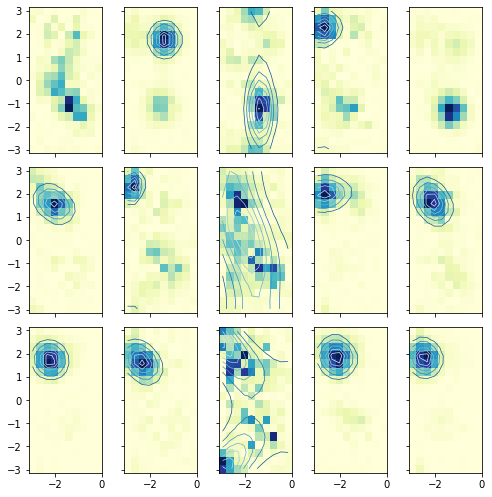

In [201]:
# Data to fit (2D)
wdir = '.'
#map_id = 15
fig, ax = plt.subplots(3,5, figsize=(7,7), sharey=True, sharex=True)
print_possible = True
fit_params = np.empty(shape=(15,6))
for map_id in range(1, 16):
    data = np.load(f"{wdir}/../Maps/{str(map_id)}_18x10.npy")
    data = data/data.max()

    # Coordinate space to calculate the function for:
    Phi, Psi = np.meshgrid(np.linspace(0, pi/2, data.shape[1]),
                           np.linspace(0, pi, data.shape[0]))

    #initial_guess = moments(data)

    initial_guess = [1., -1.5, 2, 1, 1, .1]
    try:
        popt, pcov = optimize.curve_fit(vM_bivar2, (Phi, Psi), data.ravel(), initial_guess)
        print_possible = True
    except:
        print_possible = False
        pass

    # Calculating fit data with the obtained parameters
    fit_data = vM_bivar2((Phi, Psi), *popt)
    fit_data = np.reshape(fit_data, data.shape)

    ## Visualisation

    ax[(map_id-1)//5, (map_id-1)%5].imshow(data, cmap=plt.cm.YlGnBu, extent=(-1*pi, 0, -1*pi, pi))
#plt.title('Data and Fit')
    if print_possible:
        ax[(map_id-1)//5, (map_id-1)%5].contour(fit_data, linewidths=0.7, 
                                                cmap=plt.cm.Blues_r, extent=(-1*pi, 0, -1*pi, pi), origin='upper')
        fit_params[map_id-1]=popt
    else:
        fit_params[map_id-1]=[0, 0, 0, 0, 0, 0]

#plt.figure()
#plt.title('Fit')
#plt.imshow(fit_data, cmap=plt.cm.YlGnBu, extent=(-1*pi, 0, -1*pi, pi))
#plt.figure()
#plt.imshow(pcov)
#print(popt)
fig.tight_layout()
fig.savefig('./wG_fits.png', format='png', dpi=150)

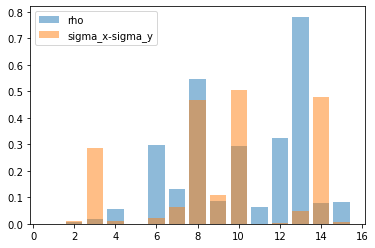

In [200]:
plt.bar(x=[x for x in range(1, 16)], height=abs(fit_params[:, -1]), alpha=0.5, label='rho')
plt.bar(x=[x for x in range(1, 16)], height=(abs(-fit_params[:, -2]+fit_params[:, -3])), alpha=0.5, label='sigma_x-sigma_y')
plt.legend()

In [ ]:
def vM_bivar3(coord_data_tuple, I, phi0, psi0, stdev_phi, stdev_psi, rho):
    phi, psi = coord_data_tuple
    phi = phi.ravel()
    psi = psi.ravel()
    
    f = I * np.exp(- 1/(2*(1-rho**2))*( 
                   ( (np.cos((phi-phi0))/stdev_phi))**2 - 
                   2*rho*np.cos(phi-phi0)*np.cos(psi-psi0)/(stdev_phi*stdev_psi) 
                   + (np.cos(psi-psi0)/stdev_psi)**2) )
    return f

In [233]:
phi0, psi0

(0.5235987755982988, 0.7391982714328925)

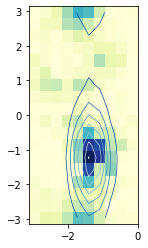

In [246]:
map_id = 3
data = np.load(f"{wdir}/../Maps/{str(map_id)}_18x10.npy")
data = data/data.max()

Phi, Psi = np.meshgrid(np.linspace(0, pi/2, data.shape[1]),
                       np.linspace(0, pi, data.shape[0]))

abs_max = data.argmax()
ind = np.unravel_index(abs_max, data.shape)
grid_1d = np.vstack((Phi.ravel(), Psi.ravel()))
phi0, psi0 = grid_1d[:, abs_max]

initial_guess = [1., phi0, psi0, 1, 1, .1]
#bounds=((0,1), (phi0-0.01, phi0+0.01), (psi0-0.01, psi0+0.01), (-np.inf,  np.inf), (-np.inf,  np.inf), (-np.inf,  np.inf))

bounds = ([0, phi0-0.0001, psi0-0.0001, -np.inf, -np.inf, -np.inf], [1, phi0+0.0001, psi0+0.0001, np.inf, np.inf, np.inf])

popt, pcov = optimize.curve_fit(vM_bivar2, (Phi, Psi),  data.ravel(), initial_guess, )#bounds=bounds)

fit_data = vM_bivar2((Phi, Psi), *popt)
fit_data = np.reshape(fit_data, data.shape)
plt.imshow(data, cmap=plt.cm.YlGnBu, extent=(-1*pi, 0, -1*pi, pi))
plt.contour(fit_data, linewidths=0.7, 
           cmap=plt.cm.Blues_r, extent=(-1*pi, 0, -1*pi, pi), origin='upper')

Andrey's function

In [ ]:
#!/usr/bin/python3
'usage: ./gauss.py input.npy ==> ... '

import os, sys
import numpy as np
from scipy.optimize import curve_fit
from math import *

f = data
dx, dy = pi/2/f.shape[0], pi/f.shape[1]
X = [(dx*(i+.5), dy*(j+.5)) for i in range(f.shape[0]) for j in range(f.shape[1])]
Y = [f[i][j] for i in range(f.shape[0]) for j in range(f.shape[1])]

func = lambda X, C, phi0, psi0, Cphi, Cpsi: C*np.exp(Cphi*np.cos((X[:,0]-phi0)*4) + Cpsi*np.cos((X[:,1]-psi0)*2)) 

popt, pcov = curve_fit(func, X, Y) 

print(popt)
